In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.path import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as mcolors
from geopy.distance import geodesic
from matplotlib import gridspec

In [5]:
# Load IBTrACS data
data = pd.read_csv('Data_TC/Proc/JTWC_Hurdat_1999_2018.csv') #IBTrACS data

data['ISO_TIME'] = pd.to_datetime(data['ISO_TIME'])
data = data[(data['ISO_TIME'] >= '1999-03-01') & (data['ISO_TIME'] <= '2018-12-31')]
data = data[(data['USA_LAT'] >= -60) & (data['USA_LAT'] <= 60) &
            (data['USA_WIND'] > 34)]
data['USA_LON'] = np.where(data['USA_LON'] < 0, data['USA_LON'] + 360, data['USA_LON'])


def calculate_motion_vectors(df):
    df = df.sort_values(by='ISO_TIME').reset_index(drop=True)
    
    vx, vy = [np.nan], [np.nan]  
    for i in range(1, len(df)):
        prev_point = (df['USA_LAT'].iloc[i-1], df['USA_LON'].iloc[i-1])
        curr_point = (df['USA_LAT'].iloc[i], df['USA_LON'].iloc[i])

        distance_m = geodesic(prev_point, curr_point).meters
        
        delta_lon = np.radians(df['USA_LON'].iloc[i] - df['USA_LON'].iloc[i-1])
        lat1 = np.radians(df['USA_LAT'].iloc[i-1])
        lat2 = np.radians(df['USA_LAT'].iloc[i])
        
        x = np.sin(delta_lon) * np.cos(lat2)
        y = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
        bearing = np.arctan2(x, y)

        time_diff = 21600  # seconds
        vx.append(distance_m * np.sin(bearing) / time_diff)
        vy.append(distance_m * np.cos(bearing) / time_diff) 

    df['vx'] = vx
    df['vy'] = vy

    return df

data = data.groupby('SID', group_keys=False).apply(calculate_motion_vectors).reset_index(drop=True)
data = data.dropna(subset=['vx', 'vy'])

data['lat_bin'] = (data['USA_LAT'] // 5) * 5
data['lon_bin'] = (data['USA_LON'] // 5) * 5

data = data[~((data['USA_LON'] > 1) & (data['USA_LON'] < 10))]
grid_grouped = data.groupby(['lat_bin', 'lon_bin']).agg(
    avg_vx=('vx', 'mean'), 
    avg_vy=('vy', 'mean'),
    num_years=('ISO_TIME', lambda x: x.dt.year.nunique()) 
).reset_index()

grid_grouped = grid_grouped[grid_grouped['num_years'] >= 4]
grid_grouped['speed'] = np.sqrt(grid_grouped['avg_vx']**2 + grid_grouped['avg_vy']**2)

grid_size = 5
lon_bins = np.arange(0, 360 + grid_size, grid_size) 
lat_bins = np.arange(-60, 60 + grid_size, grid_size)

speed_grid_obs = np.full((len(lat_bins), len(lon_bins)), np.nan) 
for i, row in grid_grouped.iterrows():
    lon_idx = np.searchsorted(lon_bins, row['lon_bin'], side='right') - 1
    lat_idx = np.searchsorted(lat_bins, row['lat_bin'], side='right') - 1

    if 0 <= lon_idx < speed_grid_obs.shape[1] and 0 <= lat_idx < speed_grid_obs.shape[0]:
        speed_grid_obs[lat_idx, lon_idx] = row['speed']

In [6]:
# Define the list of file paths for IAP-CAS
file_paths = [
    'Data_TC/Proc/ID_merged_all_track_week1_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week2_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week3_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week4_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week5_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week6_lag0_1999_2018_global_jan_dec.csv',
    'Data_TC/Proc/ID_merged_all_track_week7_lag0_1999_2018_global_jan_dec.csv'
]

# Define the polygon coordinates to exclude
polygon_coords = np.array([[300, 0], [300, -40], [355, -40], [355, 0]])

# Create a Path object for the polygon
polygon_path = Path(polygon_coords)

# Function to check if points are within the polygon
def is_within_polygon(lon, lat):
    return polygon_path.contains_point((lon, lat))


# Define the list of SID prefixes to include
sid_prefixes = ('11', '12', '13', '14', '21', '22', '23', '24', '31', '33', '34', '41', '42', '43', '44')


def calculate_motion_vectors(df1):
    df1 = df1.sort_values(by='ISO_TIME').reset_index(drop=True)
    
    vxx, vyy = [np.nan], [np.nan]
    for i in range(1, len(df1)):
        prev_point = (df1['lat_ni_f'].iloc[i-1], df1['lon_ni_f'].iloc[i-1])
        curr_point = (df1['lat_ni_f'].iloc[i], df1['lon_ni_f'].iloc[i])

        distance_m = geodesic(prev_point, curr_point).meters
        delta_lon = np.radians(df1['lon_ni_f'].iloc[i] - df1['lon_ni_f'].iloc[i-1])
        lat1, lat2 = np.radians(df1['lat_ni_f'].iloc[i-1]), np.radians(df1['lat_ni_f'].iloc[i])

        xx = np.sin(delta_lon) * np.cos(lat2)
        yy = np.cos(lat1) * np.sin(lat2) - (np.sin(lat1) * np.cos(lat2) * np.cos(delta_lon))
        bearing = np.arctan2(xx, yy)

        time_diff = 21600  # 6 hours in seconds

        vxx.append(distance_m * np.sin(bearing) / time_diff)
        vyy.append(distance_m * np.cos(bearing) / time_diff)

    df1['vxx'], df1['vyy'] = vxx, vyy
    return df1


week_results = {}
for idx, file_path in enumerate(file_paths):
    data1 = pd.read_csv(file_path)
    data1['ISO_TIME'] = pd.to_datetime(data1[['year', 'month', 'day', 'hour']])
    data1 = data1[(data1['ISO_TIME'].dt.year >= 1999) & (data1['ISO_TIME'].dt.year <= 2018)]
    data1 = data1[(data1['lat_ni_f'] >= -60) & (data1['lat_ni_f'] <= 60) & 
                (data1['lon_ni_f'] >= 0) & (data1['lon_ni_f'] <= 360) & 
                (data1['wind'] > 1)]

    data1 = data1[~data1.apply(lambda row: is_within_polygon(row['lon_ni_f'], row['lat_ni_f']), axis=1)]
    all_grid_data1 = []

    for prefix in sid_prefixes:
        data_prefix1 = data1[data1['SID'].astype(str).str.startswith(prefix)]
        data_prefix1 = data_prefix1.groupby('SID', group_keys=False).apply(calculate_motion_vectors).reset_index(drop=True)
        
        data_prefix1 = data_prefix1.dropna(subset=['vxx', 'vyy'])
        data_prefix1['lat_bin1'] = (data_prefix1['lat_ni_f'] // 5) * 5
        data_prefix1['lon_bin1'] = (data_prefix1['lon_ni_f'] // 5) * 5
        data_filtered1 = data_prefix1.groupby(['lat_bin1', 'lon_bin1']).filter(lambda x: x['ISO_TIME'].dt.year.nunique() >= 4)
        grid_grouped1 = data_filtered1.groupby(['lat_bin1', 'lon_bin1']).agg(
            avg_vxx=('vxx', 'mean'),
            avg_vyy=('vyy', 'mean'),
            num_years=('ISO_TIME', lambda x: x.dt.year.nunique())
        ).reset_index()
        
        grid_grouped1['speed'] = np.sqrt(grid_grouped1['avg_vxx']**2 + grid_grouped1['avg_vyy']**2)
        all_grid_data1.append(grid_grouped1)
    combined_grid_data1 = pd.concat(all_grid_data1, ignore_index=True)
    week_results[f'week{idx+1}_all'] = combined_grid_data1


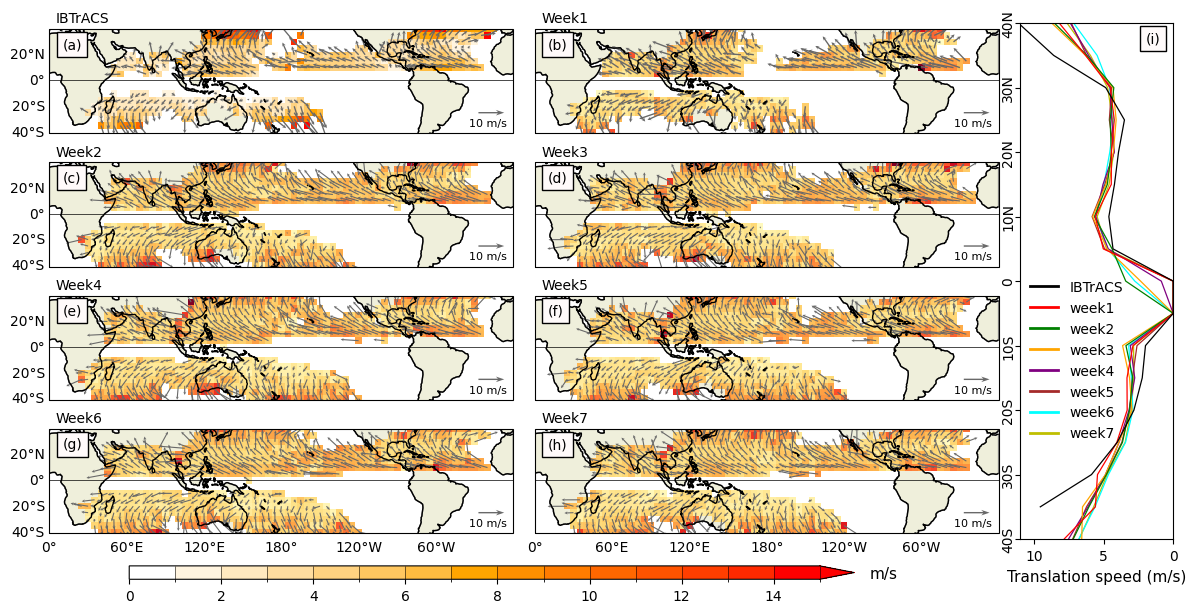

In [7]:
import warnings
warnings.filterwarnings('ignore')
from matplotlib import gridspec

custom_cmap = plt.cm.YlOrRd
norm = mcolors.Normalize(vmin=0, vmax=16)

fig = plt.figure(figsize=(14.5, 6.7))
gs = gridspec.GridSpec(4, 3, figure=fig, width_ratios=[1, 1, 0.33], height_ratios=[1, 1, 1, 1])
axs = [fig.add_subplot(gs[row, col], projection=ccrs.PlateCarree(central_longitude=180)) for row in range(4) for col in range(2)]

grid_size = 5
lon_bins = np.arange(0, 360 + grid_size, grid_size)
lat_bins = np.arange(-60, 60 + grid_size, grid_size)

for idx, (week_key, combined_grid_data1) in enumerate(week_results.items()):
    speed_grid = np.full((len(lat_bins), len(lon_bins)), np.nan)
    for i, row in combined_grid_data1.iterrows():
        lon_idx = np.where(lon_bins == row['lon_bin1'])[0]
        lat_idx = np.where(lat_bins == row['lat_bin1'])[0]
        if lon_idx.size > 0 and lat_idx.size > 0:
            speed_grid[lat_idx[0], lon_idx[0]] = row['speed']

    if not combined_grid_data1.empty:
        ax1 = axs[idx + 1] 

        ax1.add_feature(cfeature.LAND, edgecolor='gray')
        ax1.add_feature(cfeature.COASTLINE)

        # Add gridlines and set axis labels
        gl = ax1.gridlines(draw_labels=True, color='none')
        gl.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
        gl.xlocator = plt.FixedLocator(np.arange(-180, 180, 60))  
        
        gl.top_labels, gl.right_labels = False, False

        if idx in {1, 3, 5}:  # Check if idx is 1, 3, or 5
           gl.left_labels = True
        else:  
          gl.left_labels = False
        
        if idx < 5:  
            gl.bottom_labels = False
        else:  
            gl.bottom_labels = True
        shading = ax1.pcolormesh(lon_bins, lat_bins, speed_grid, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())

        reduced_grid_grouped = combined_grid_data1[combined_grid_data1['num_years'] >= 4]
        reduced_grid_grouped = reduced_grid_grouped.drop_duplicates(subset=['lat_bin1', 'lon_bin1'])
        quiver = ax1.quiver(
            reduced_grid_grouped['lon_bin1'], 
            reduced_grid_grouped['lat_bin1'],  
            reduced_grid_grouped['avg_vxx'],   
            reduced_grid_grouped['avg_vyy'],   
            color='dimgrey', 
            angles='xy', 
            scale_units='xy', 
            scale=0.5,         
            linewidth=0.05,    
            headlength=3,     
            headwidth=3,       
            headaxislength=2,  
            transform=ccrs.PlateCarree()
        )

        ref_vector_length = 10  
        scale_factor = 0.5    
        x_max, x_min = ax1.get_xlim()
        y_max, y_min = ax1.get_ylim()
        x_position = 0.15 * x_max  
        y_position = 0.4 * y_max   
        text_x_position = 0.11 * x_max  
        text_y_position = 0.53 * y_max  

        ref_vector = ax1.quiver(
            np.array([x_position]), np.array([y_position]),  
            np.array([ref_vector_length]), np.array([0]),    
            color='dimgrey',
            angles='xy',
            scale_units='xy',
            scale=0.5,
            width=0.003,      
            headlength=6,      
            headwidth=4,       
            transform=ccrs.PlateCarree()
        )

        label_text = f'{ref_vector_length} m/s'
        ax1.text(
            text_x_position, text_y_position, label_text,
            transform=ccrs.PlateCarree(),
            fontsize=8,
            ha='center', va='center',
            bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
        )

        ax1.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())

#.........................................................................................................................................................
ax1 = axs[0]
ax1.add_feature(cfeature.LAND, edgecolor='gray') 
ax1.add_feature(cfeature.COASTLINE)

# Add gridlines
gl1 = ax1.gridlines(draw_labels=True, linewidth=0.001)
gl1.top_labels = False
gl1.right_labels = False
gl1.xlabels_bottom = False  # Show x labels at the bottom
gl1.ylocator = plt.FixedLocator(np.arange(-40, 41, 20))  
gl1.ylabels_left = True  # Show y labels on the left

colors = ["white", "orange", "red",]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("white_yellow_red", colors, N=17)  
norm = mcolors.BoundaryNorm(boundaries=np.linspace(0, 15, 16), ncolors=17)
shading = ax1.pcolormesh(lon_bins, lat_bins, speed_grid_obs, cmap=custom_cmap, norm=norm, transform=ccrs.PlateCarree())


quiver = ax1.quiver(
    grid_grouped['lon_bin'],  
    grid_grouped['lat_bin'],  
    grid_grouped['avg_vx'],   
    grid_grouped['avg_vy'],   
    color='dimgrey', 
    angles='xy', 
    scale_units='xy', 
    scale=0.5,         
    linewidth=0.05,   
    headlength=3,      
    headwidth=3,    
    headaxislength=2,  
    transform=ccrs.PlateCarree()
)

ref_vector_length = 10  
scale_factor = 0.5    

# Retrieve axis limits
x_max, x_min = ax1.get_xlim()
y_max, y_min = ax1.get_ylim()

x_position = 0.15 * x_max  
y_position = 0.4 * y_max  

text_x_position = 0.11 * x_max  
text_y_position = 0.53 * y_max   

ref_vector = ax1.quiver(
    np.array([x_position]), np.array([y_position]),  
    np.array([ref_vector_length]), np.array([0]),  
    color='dimgrey',
    angles='xy',
    scale_units='xy',
    scale=0.5,
    width=0.003,       
    headlength=6,      
    headwidth=4,       
    transform=ccrs.PlateCarree()
)

x_max, x_min = ax1.get_xlim()
y_max, y_min = ax1.get_ylim()


label_text = f'{ref_vector_length} m/s'
ax1.text(
    text_x_position, text_y_position, label_text,
    transform=ccrs.PlateCarree(),
    fontsize=8,
    ha='center', va='center',
    bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.2')
)

ax1.set_extent([-180, 180, -41, 40], crs=ccrs.PlateCarree())
cbar_axx = fig.add_axes([0.18, 0.05, 0.5, 0.02])  
cbarr = fig.colorbar(shading, cax=cbar_axx, orientation='horizontal', extend='max', drawedges=True)
fig.text(0.7, 0.059, 'm/s', ha='center', va='center', rotation='horizontal', fontsize=11)  


#.......................................................................................................................................................
line_ax = fig.add_subplot(gs[:, 2])  

#For line plot
dff=pd.read_csv('Data_TC/Proc/latitudinal_average_translation_wind.csv')

line_ax.plot(dff.week7, dff.lat, color='y', label='week7', linewidth=0.9)
line_ax.plot(dff.week6, dff.lat, color='cyan', label='week6', linewidth=0.9)
line_ax.plot(dff.week5, dff.lat, color='brown', label='week5', linewidth=0.9)
line_ax.plot(dff.week4, dff.lat, color='purple', label='week4', linewidth=0.9)
line_ax.plot(dff.week3, dff.lat, color='orange', label='week3', linewidth=0.9)
line_ax.plot(dff.week2, dff.lat, color='green', label='week2', linewidth=0.9)
line_ax.plot(dff.week1, dff.lat, color='red', label='week1', linewidth=0.9)
line_ax.plot(dff.obss, dff.lat, color='k', label='IBTrACS', linestyle='-', linewidth=0.9)


solid_lines = [
    plt.Line2D([0], [0], color='k', linestyle='-', label='IBTrACS', linewidth=2,),
    plt.Line2D([0], [0], color='red', linestyle='-', label='week1', linewidth=2,),
    plt.Line2D([0], [0], color='green', linestyle='-', label='week2', linewidth=2),
    plt.Line2D([0], [0], color='orange', linestyle='-', label='week3', linewidth=2),
    plt.Line2D([0], [0], color='purple', linestyle='-', label='week4', linewidth=2),
    plt.Line2D([0], [0], color='brown', linestyle='-', label='week5', linewidth=2),
    plt.Line2D([0], [0], color='cyan', linestyle='-', label='week6', linewidth=2),
    plt.Line2D([0], [0], color='y', linestyle='-', label='week7', linewidth=2)
]

line_ax.legend(handles=solid_lines, ncol=1, loc=(0.03, 0.18),fontsize=10, frameon=False,) 

line_ax.set_ylim(-40, 40)
line_ax.set_xlim(11, 0)


line_ax.set_yticklabels(['40S', '30S', '20S', '10S', '0', '10N', '20N', '30N', '40N'], fontsize=10, rotation=90, va="center")
line_ax.tick_params(axis='y', pad=0.1)

line_ax.set_xticklabels(['0', '5', '10'], fontsize=10, va="center") 
line_ax.tick_params(axis='x', pad=9)

line_ax.text(2, 37, '(i)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
line_ax.set_xlabel('Translation speed (m/s)',fontsize=11,)

# Add text 
axs[0].text(-170, 25, '(a)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[1].text(-170, 25, '(b)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[2].text(-170, 25, '(c)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[3].text(-170, 25, '(d)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[4].text(-170, 25, '(e)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[5].text(-170, 25, '(f)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[6].text(-170, 25, '(g)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))
axs[7].text(-170, 25, '(h)', fontsize=10, color='k', bbox=dict(facecolor='snow', alpha=1))

# Add titles 
axs[0].text(-175, 45, 'IBTrACS', fontsize=10, color='k')  
axs[1].text(-175, 45, 'Week1', fontsize=10, color='k')    
axs[2].text(-175, 45, 'Week2', fontsize=10, color='k')    
axs[3].text(-175, 45, 'Week3', fontsize=10, color='k')   
axs[4].text(-175, 45, 'Week4', fontsize=10, color='k')    
axs[5].text(-175, 45, 'Week5', fontsize=10, color='k')    
axs[6].text(-175, 45, 'Week6', fontsize=10, color='k')   
axs[7].text(-175, 45, 'Week7', fontsize=10, color='k')   


for ax in axs:
    ax.axhline(0, color='k', linewidth=0.5)  
plt.subplots_adjust(wspace=0.06, hspace=0.15)

#plt.savefig('Figures/Figure12.png', dpi=400, bbox_inches='tight')
plt.show()
